In [151]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import sys
import math
import time
import importlib
# from tordch.utils.tensorboard import SummaryWriter

import yaml

In [122]:
import scripts.preprocessing 
importlib.reload(scripts.preprocessing)
from scripts.preprocessing import *

In [148]:
with open('params.yaml', 'r') as file:
    config = yaml.safe_load(file)

batch_size = config['training']['batch_size']
num_epochs = config['training']['num_epochs']
lr = config['training']['lr']


In [137]:
# Loading the Data

X_test = np.load("data/project/X_test.npy")
y_test = np.load("data/project/y_test.npy")
person_train_valid = np.load("data/project/person_train_valid.npy")
X_train_valid = np.load("data/project/X_train_valid.npy")
y_train_valid = np.load("data/project/y_train_valid.npy")
person_test = np.load("data/project/person_test.npy")

print(X_train_valid.shape)
print(y_train_valid.shape)
print(X_test.shape)
print(y_test.shape)
print(person_train_valid.shape)
print(person_test.shape)


## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

(2115, 22, 1000)
(2115,)
(443, 22, 1000)
(443,)
(2115, 1)
(443, 1)


In [138]:
# FOR SUBJECT SPECIFICALLY

X_train_valid_split, y_train_valid_split, X_test_split, y_test_split = initialize_subject_data(person_train_valid,person_test, X_train_valid, y_train_valid)

# Proprocessing

In [139]:
# 1.  Splitting

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, shuffle=True)

# 2. Trim
X_train, X_valid, X_test = trim(X_train, X_valid, X_test, 0.8)
print(X_train.shape, X_valid.shape, X_test.shape)

# 3. Augmentation
# print(X_train.shape, X_test.shape)

# X_train_aug, y_train_aug, X_test_aug, y_test_aug = augment(X_train, y_train, X_test, y_test, sub_sample=2, average=2, noise=0.5, noid=1)
# print(X_train.shape, X_valid.shape, X_test.shape)

(1692, 22, 800) (423, 22, 800) (443, 22, 800)


In [140]:
# X_train, y_train, X_test, y_test = X_train_aug, y_train_aug, X_test_aug, y_test_aug
# print(X_train.shape, X_valid.shape, X_test.shape)

In [141]:
# Creating Dataset instances
train_set = EEGDataset(X_train, y_train)
val_set = EEGDataset(X_valid, y_valid)
test_set = EEGDataset(X_test, y_test)

# train_set_s0 = EEGDataset(X_train_s0, y_train_s0)
# val_set_s0 = EEGDataset(X_valid_s0, y_valid_s0)
# test_set_s0 = EEGDataset(X_test_prep_s0, y_test_prep_s0)


print(train_set.shape())
print(val_set.shape())
print(test_set.shape())
# print(train_set_s0.shape())
# print(val_set_s0.shape())
# print(test_set_s0.shape())

torch.Size([1692, 1, 800, 22])
torch.Size([423, 1, 800, 22])
torch.Size([443, 1, 800, 22])


# DataLoaders

In [142]:
# Initializing DataLoaders with concise batch_size and shuffle parameters


train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# train_loader_s0 = DataLoader(train_set_s0, batch_size=128, shuffle=True)
# val_loader_s0 = DataLoader(val_set_s0, batch_size=50, shuffle=False)
# test_loader_s0 = DataLoader(test_set_s0, batch_size=50, shuffle=False)

# Transformer model

### Multihead Attention

In [143]:
# Allowing the model to attend to information from multiple representation subspaces, at different positions

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model # Dimension of the model
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head
        
        # Query, key, value, output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    # Core attention mechanism - dot product of query + key and scaling. 
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        # Outputs weighted sum of values

    # Split input tensor into multiple heads for parallel processing
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    # Concatenates heads back
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    # Forward Pass
    def forward(self, Q, K, V, mask=None):

        # Calculate query, key and values and split into multiple heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        # Compute dot product attention for each head in parallel
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

### Position Wise Feed Forward

In [144]:
# Simple 2 layer

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

# It receives output from multiheadattention, transforms into higher dimension, ReLU and then back
# Acts as a FC layer for each position

### Positional Encoding

In [72]:
# Injects information about the position of each element in the sequence, allowing the model to utilize the order of the data

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)

        # Calculates position of each element in the sequence
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        # Allows model to learn to attend by relative positions, using geometric progressions
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term) # Even
        pe[:, 1::2] = torch.cos(position * div_term) # Odd
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Ensures model considers order of the sequence

## Encoder
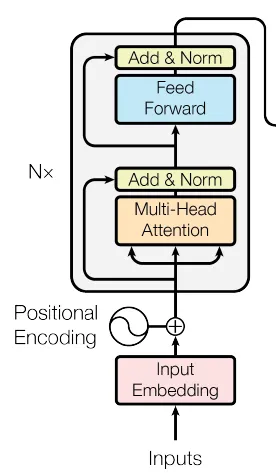

In [73]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Multihead, dropout+normalization, feed forward, another dropout+norm

## Decoder
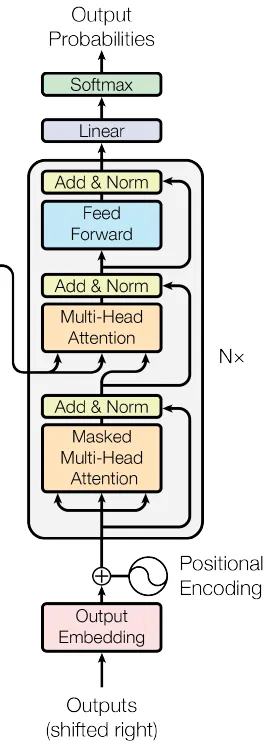

In [74]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x
        
# 1. masked self-attention output, add to input w dropout/norm. 
# 2. Cross attention between the decoder and encoder outputs, add it to masked self att w dropout/norm.
# 3. Position wide feed forward with normalized cross attention, etc

## Transformer
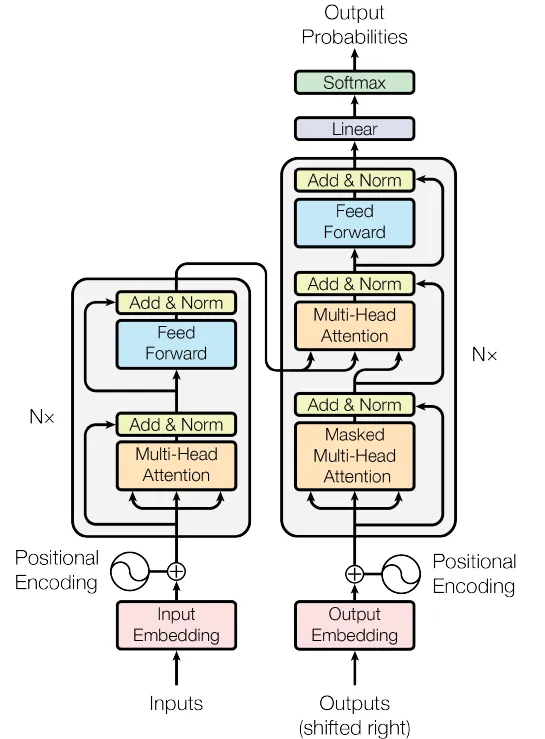

In [75]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    # Generate binary masks for source and target sequences to ignore padding tokens and not attend to future tokens
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)

        # Compute Embeddings
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        # Encoder Layers
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        # Decoder Layers
        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

# Training

In [145]:
# src_vocab_size = 5000
# tgt_vocab_size = 5000
# d_model = 512
# num_heads = 8
# num_layers = 6
# d_ff = 2048
# max_seq_length = 100
# dropout = 0.1

src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 22
num_heads = 4
num_layers = 4
d_ff = 1024
max_seq_length = 100 # Change this!
dropout = 0.1

In [149]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))
# tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))

In [152]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

val_acc_history = []
train_acc_history = []
train_loss_history = []
val_loss_history = []

t0 = time.time()

for epoch in range(num_epochs):
    tstart = time.time()
    transformer.train()
    train_cons, train_total = 0,0
    train_loss = 0.0

    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        _, predlabels = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_cons += (predlabels == labels).sum().item()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= train_total
    train_acc = train_cons / train_total
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Validation phase
    model.eval()
    val_cons, val_total = 0, 0
    val_loss = 0.0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            # val_inputs, val_labels = val_inputs.cuda(), val_labels.cuda()  # Uncomment if using CUDA
            val_outputs = model(val_inputs)
            _, predlabels_v = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_cons += (predlabels_v == val_labels).sum().item()
            val_loss += criterion(val_outputs, val_labels).item() * val_inputs.size(0)  # Multiply by batch size

    val_loss /= val_total
    val_acc = val_cons / val_total
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    # Save model checkpoint optionally based on validation performance
    torch.save(model.state_dict(), "./transformer.pt")

    print(f'Epoch: {epoch+1:<3d} | '
          f'Train Loss: {train_loss:<3.3f} | Train Acc: {train_acc:<1.3f} | '
          f'Val Loss: {val_loss:<3.3f} | Val Acc: {val_acc:<1.3f} | '
          )
    tend = time.time()
    print(f'Epoch Time: {tend - tstart:<3.2f}s')


time_total = time.time() - t0
print(f'Total time: {time_total:4.3f} seconds, average time per epoch: {time_total / num_epochs:4.3f}')

TypeError: forward() missing 1 required positional argument: 'tgt'

In [78]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(100):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.69168758392334
Epoch: 2, Loss: 8.50415325164795
Epoch: 3, Loss: 8.256058692932129
Epoch: 4, Loss: 8.834961891174316
Epoch: 5, Loss: 8.182161331176758
Epoch: 6, Loss: 8.141606330871582
Epoch: 7, Loss: 8.108220100402832
Epoch: 8, Loss: 8.058524131774902
Epoch: 9, Loss: 7.931635856628418
Epoch: 10, Loss: 7.9794602394104
Epoch: 11, Loss: 7.695684432983398
Epoch: 12, Loss: 7.891605854034424
Epoch: 13, Loss: 7.512355804443359
Epoch: 14, Loss: 7.650834560394287
Epoch: 15, Loss: 7.644824504852295
Epoch: 16, Loss: 7.267595291137695
Epoch: 17, Loss: 6.9922776222229
Epoch: 18, Loss: 6.752403736114502
Epoch: 19, Loss: 6.600681304931641
Epoch: 20, Loss: 6.2723283767700195
Epoch: 21, Loss: 6.287365913391113


KeyboardInterrupt: 